# **AutismPredictor: ANN-Based Autism Predictor**

## **Project Overview**

**AutismPredictor** is a binary classification project designed to predict the likelihood of Autism Spectrum Disorder (ASD) in individuals using survey-based screening data.  
The workflow includes exploratory data analysis (EDA), preprocessing, feature selection, artificial neural network (ANN) modeling, and deployment as an interactive Streamlit application.

## **Objective**

Build and deploy a robust ANN model to screen for autism in adults based on behavioral and demographic features, while addressing data imbalance and potential overfitting.

## **Dataset**

- **Source**: [Autism Screening on Adults Dataset](https://www.kaggle.com/datasets/andrewmvd/autism-screening-on-adults/data)  
- **Samples**: 704  
- **Features**: 15 selected features (10 behavioral scores, demographic & medical history inputs)  
- **Target**: Autism Screening Result (Positive = 1, Negative = 0)

## **Data Exploration & Preprocessing**

- Conducted **exploratory data analysis** and visualization.  
- Handled **missing values** and cleaned categorical features.  
- Applied **oversampling (RandomOverSampler)** to address class imbalance.  
- Encoded categorical features using **label encoding** and **manual mappings**.  
- Selected 15 core features for modeling.

## **Modeling & Training**

- **Architecture**:  
  - Input layer matching feature count.  
  - Hidden layers with units: 64 → 512 → 256 → 64 → 32.  
  - Techniques applied: **ReLU activation**, **Batch Normalization**, **Dropout**, and multiple forms of **regularization (L1, L2, L1_L2)**.  
  - Output layer: Dense(1, Sigmoid) for binary classification.

- **Training Setup**:  
  - Optimizer: **Adam**  
  - Loss: **Binary Crossentropy**  
  - Callback: **EarlyStopping** (patience=10, restore best weights)  
  - Batch size: 30, Epochs: 100, Validation split: 0.2  

## **Performance**

- **Training**: Accuracy = `0.9761`, Loss = `0.6163`  
- **Testing**: Accuracy = `0.9748`, Loss = `0.6175`  
- **Precision** = `0.95`, **Recall** = `1.00`, **F1-score** = `0.98`  

The model achieved **high accuracy and balanced precision-recall**, showing strong generalization without overfitting.

## **Deployment**

A **[Streamlit web app](https://autismpredictor-h6kfmers62gfwz5at9bprh.streamlit.app/)** was developed, enabling users to input screening scores, demographic details, and family history.  
The app provides **real-time predictions** of ASD likelihood in a clear and user-friendly interface.

Watch a short demo of the app here: [View on LinkedIn](https://www.linkedin.com/posts/rawan-alwadeya-17948a305_deeplearning-artificialneuralnetworks-binaryclassification-activity-7364474655748870144-_mF7?utm_source=share&utm_medium=member_desktop&rcm=ACoAAE3YzG0BAZw48kimDDr_guvq8zXgSjDgk_I)

#### **Import Necessary Libraries**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set()

from imblearn.over_sampling import RandomOverSampler
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, recall_score, f1_score, precision_score, classification_report, confusion_matrix

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input , Dense , Dropout, BatchNormalization
from tensorflow.keras import regularizers, callbacks
from tensorflow.keras.initializers import GlorotUniform

import joblib
import warnings
warnings.filterwarnings('ignore')

#### **Dataset Loading**

In [2]:
df = pd.read_csv('autism_screening.csv')
df

,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,A10_Score,...,gender,ethnicity,jundice,austim,contry_of_res,used_app_before,result,age_desc,relation,Class/ASD
0,1,1,1,1,0,0,1,1,0,0,...,f,White-European,no,no,United States,no,6.0,18 and more,Self,NO
1,1,1,0,1,0,0,0,1,0,1,...,m,Latino,no,yes,Brazil,no,5.0,18 and more,Self,NO
2,1,1,0,1,1,0,1,1,1,1,...,m,Latino,yes,yes,Spain,no,8.0,18 and more,Parent,YES
3,1,1,0,1,0,0,1,1,0,1,...,f,White-European,no,yes,United States,no,6.0,18 and more,Self,NO
4,1,0,0,0,0,0,0,1,0,0,...,f,?,no,no,Egypt,no,2.0,18 and more,?,NO
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
699,0,1,0,1,1,0,1,1,1,1,...,f,White-European,no,no,Russia,no,7.0,18 and more,Self,YES
700,1,0,0,0,0,0,0,1,0,1,...,m,Hispanic,no,no,Mexico,no,3.0,18 and more,Parent,NO
701,1,0,1,1,1,0,1,1,0,1,...,f,?,no,no,Russia,no,7.0,18 and more,?,YES
702,1,0,0,1,1,0,1,0,1,1,...,m,South Asian,no,no,Pakistan,no,6.0,18 and more,Self,NO


#### **Data Exploration and Visualization**

In [3]:
df.sample(10)

,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,A10_Score,...,gender,ethnicity,jundice,austim,contry_of_res,used_app_before,result,age_desc,relation,Class/ASD
514,1,1,1,1,1,0,1,1,1,1,...,f,White-European,no,no,United States,no,9.0,18 and more,Self,YES
67,1,0,1,0,1,1,1,1,0,0,...,m,Hispanic,no,no,United States,no,6.0,18 and more,Self,NO
654,1,1,1,1,1,0,1,1,1,1,...,m,Asian,no,no,United States,no,9.0,18 and more,Self,YES
290,1,1,1,0,1,1,1,0,1,1,...,f,White-European,no,no,Ireland,no,8.0,18 and more,Self,YES
594,1,0,0,0,1,0,0,0,1,1,...,m,Asian,no,no,India,no,4.0,18 and more,Self,NO
51,1,1,1,1,1,1,1,1,1,1,...,f,Black,no,no,France,no,10.0,18 and more,Parent,YES
589,1,1,1,0,0,0,0,0,0,0,...,f,Asian,no,no,New Zealand,no,3.0,18 and more,Self,NO
225,0,1,0,1,0,0,0,1,0,1,...,f,White-European,no,no,United States,no,4.0,18 and more,Self,NO
410,1,1,0,1,0,0,0,0,0,1,...,f,Middle Eastern,no,no,United Arab Emirates,no,4.0,18 and more,Self,NO
78,1,0,0,1,1,0,0,0,0,1,...,m,Middle Eastern,no,no,United States,no,4.0,18 and more,Self,NO


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 704 entries, 0 to 703
Data columns (total 21 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   A1_Score         704 non-null    int64  
 1   A2_Score         704 non-null    int64  
 2   A3_Score         704 non-null    int64  
 3   A4_Score         704 non-null    int64  
 4   A5_Score         704 non-null    int64  
 5   A6_Score         704 non-null    int64  
 6   A7_Score         704 non-null    int64  
 7   A8_Score         704 non-null    int64  
 8   A9_Score         704 non-null    int64  
 9   A10_Score        704 non-null    int64  
 10  age              702 non-null    float64
 11  gender           704 non-null    object 
 12  ethnicity        704 non-null    object 
 13  jundice          704 non-null    object 
 14  austim           704 non-null    object 
 15  contry_of_res    704 non-null    object 
 16  used_app_before  704 non-null    object 
 17  result          

In [5]:
df.columns

Index(['A1_Score', 'A2_Score', 'A3_Score', 'A4_Score', 'A5_Score', 'A6_Score',
       'A7_Score', 'A8_Score', 'A9_Score', 'A10_Score', 'age', 'gender',
       'ethnicity', 'jundice', 'austim', 'contry_of_res', 'used_app_before',
       'result', 'age_desc', 'relation', 'Class/ASD'],
      dtype='object')

In [6]:
df = df.drop(["ethnicity", "contry_of_res", "age_desc", "relation", "used_app_before"], axis=1)
df

,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,A10_Score,age,gender,jundice,austim,result,Class/ASD
0,1,1,1,1,0,0,1,1,0,0,26.0,f,no,no,6.0,NO
1,1,1,0,1,0,0,0,1,0,1,24.0,m,no,yes,5.0,NO
2,1,1,0,1,1,0,1,1,1,1,27.0,m,yes,yes,8.0,YES
3,1,1,0,1,0,0,1,1,0,1,35.0,f,no,yes,6.0,NO
4,1,0,0,0,0,0,0,1,0,0,40.0,f,no,no,2.0,NO
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
699,0,1,0,1,1,0,1,1,1,1,25.0,f,no,no,7.0,YES
700,1,0,0,0,0,0,0,1,0,1,34.0,m,no,no,3.0,NO
701,1,0,1,1,1,0,1,1,0,1,24.0,f,no,no,7.0,YES
702,1,0,0,1,1,0,1,0,1,1,35.0,m,no,no,6.0,NO


In [7]:
df.isna().sum()

A1_Score     0
A2_Score     0
A3_Score     0
A4_Score     0
A5_Score     0
A6_Score     0
A7_Score     0
A8_Score     0
A9_Score     0
A10_Score    0
age          2
gender       0
jundice      0
austim       0
result       0
Class/ASD    0
dtype: int64

In [8]:
df.describe()

,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,A10_Score,age,result
count,704.000000,704.000000,704.000000,704.000000,704.000000,704.000000,704.000000,704.000000,704.000000,704.000000,702.000000,704.000000
mean,0.721591,0.453125,0.457386,0.495739,0.498580,0.284091,0.417614,0.649148,0.323864,0.573864,29.698006,4.875000
std,0.448535,0.498152,0.498535,0.500337,0.500353,0.451301,0.493516,0.477576,0.468281,0.494866,16.507465,2.501493
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,17.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,21.000000,3.000000
50%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,27.000000,4.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,35.000000,7.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,383.000000,10.000000


In [9]:
df.duplicated().sum()

27

In [10]:
df = df.drop_duplicates()

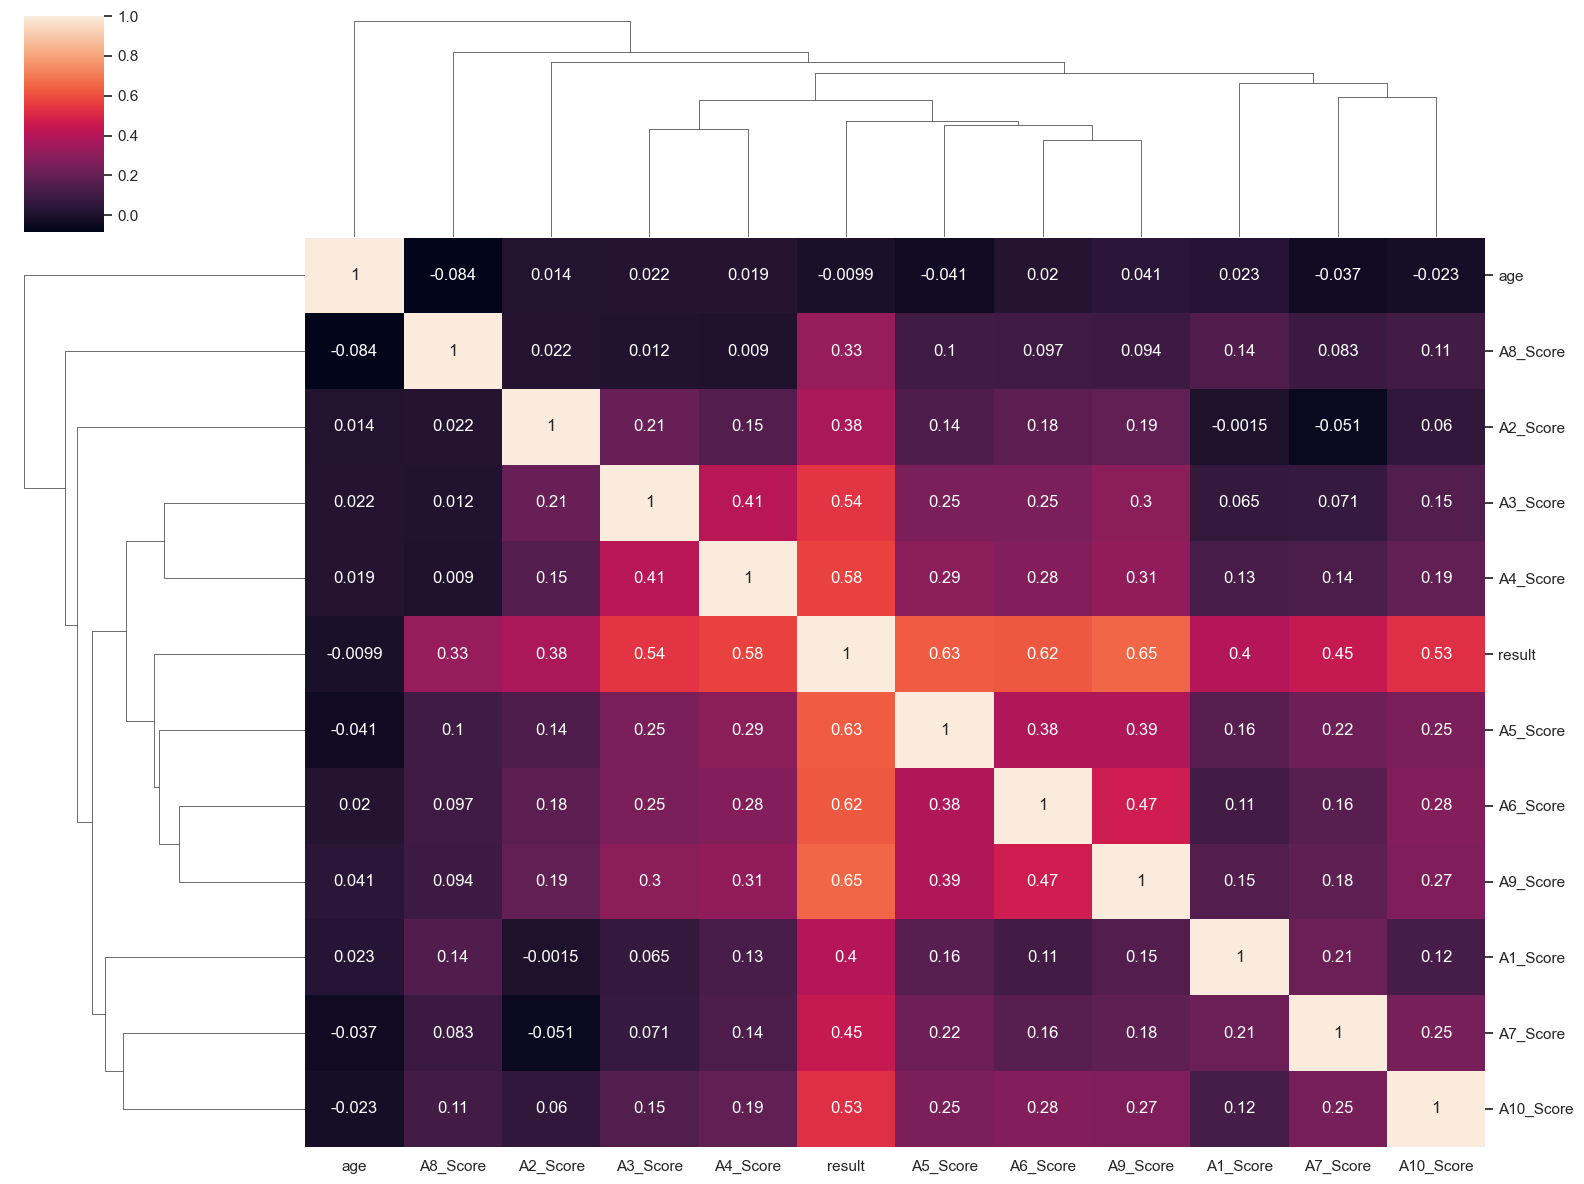

In [11]:
sns.clustermap(df.corr(numeric_only=True), annot=True, figsize=(16, 12))
plt.show()

In [12]:
df.skew(numeric_only=True)

A1_Score     -0.970401
A2_Score      0.205363
A3_Score      0.181345
A4_Score      0.008882
A5_Score     -0.008882
A6_Score      0.962299
A7_Score      0.326990
A8_Score     -0.582756
A9_Score      0.770835
A10_Score    -0.320835
age          14.188488
result        0.303535
dtype: float64

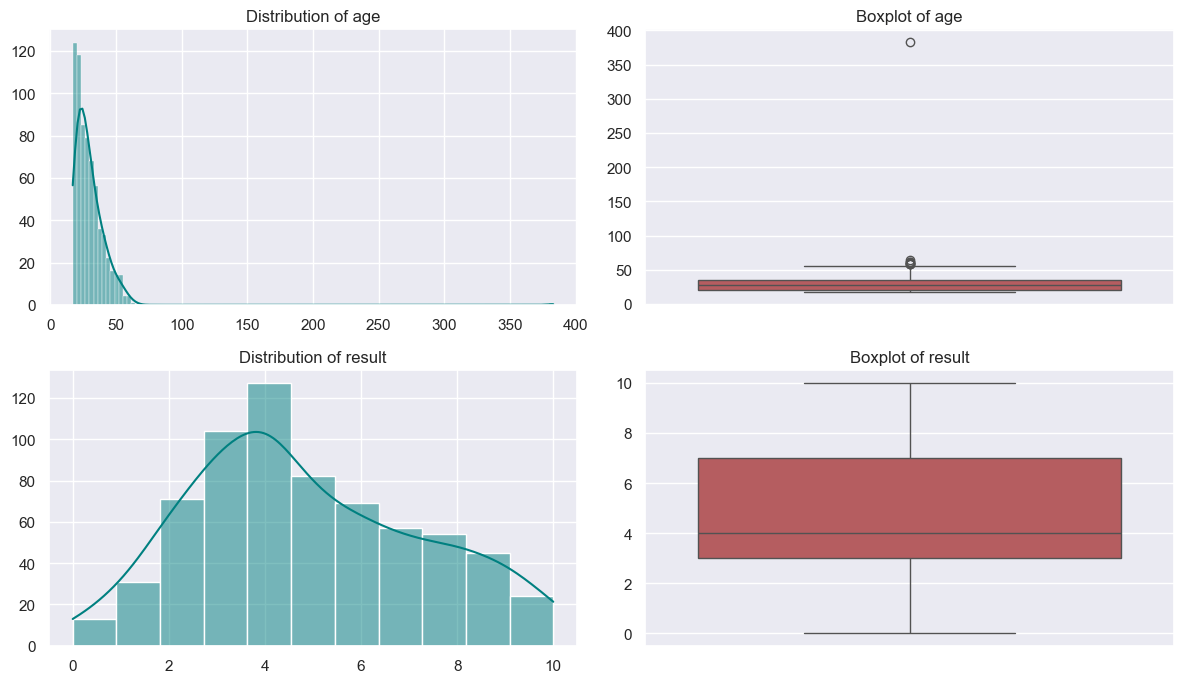

In [13]:
features = ['age', 'result']

plt.figure(figsize=(12, len(features) * 3.5))

for i, col in enumerate(features):
    plt.subplot(len(features), 2, i * 2 + 1)
    sns.histplot(df[col], kde=True, color='teal')
    plt.title(f"Distribution of {col}")
    plt.xlabel('')  
    plt.ylabel('')

    plt.subplot(len(features), 2, i * 2 + 2)
    sns.boxplot(y=df[col], color='r')
    plt.title(f"Boxplot of {col}")
    plt.xlabel('')
    plt.ylabel('')

plt.tight_layout()
plt.show()

Outliers in Age: 1.18% of the data


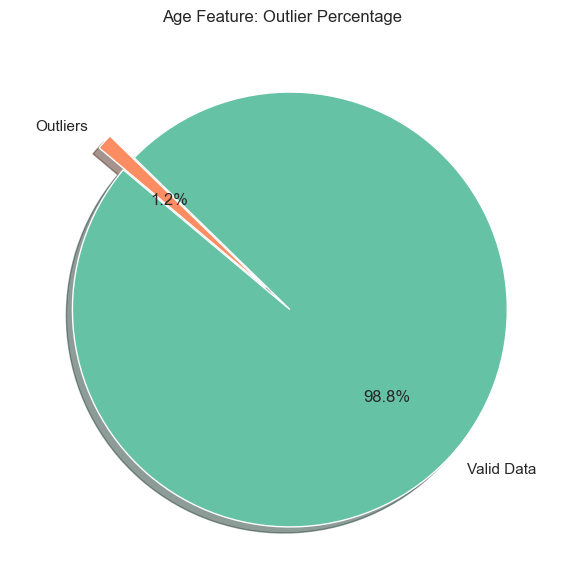

In [14]:
Q1 = df['age'].quantile(0.25)
Q3 = df['age'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

n_total = len(df)
n_outliers = ((df['age'] < lower_bound) | (df['age'] > upper_bound)).sum()
n_retained = n_total - n_outliers

outlier_percentage = (n_outliers / n_total) * 100
print(f"Outliers in Age: {outlier_percentage:.2f}% of the data")

pie_data = [n_retained, n_outliers]
labels = ['Valid Data', 'Outliers']
colors = sns.color_palette("Set2", 2)  
explode = (0.05, 0.1)  

plt.figure(figsize=(6, 6))
plt.pie(
    pie_data,
    labels=labels,
    colors=colors,
    autopct='%1.1f%%',
    startangle=140,
    explode=explode,
    shadow=True,
    wedgeprops={'edgecolor': 'white'}
)

plt.title('Age Feature: Outlier Percentage', fontsize=12)
plt.tight_layout()
plt.show()

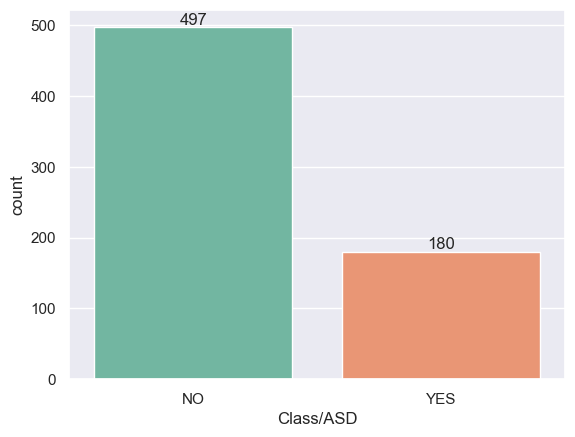

In [15]:
ax = sns.countplot(data=df, x='Class/ASD', palette='Set2')

for p in ax.patches:
    height = p.get_height()
    ax.text(
        p.get_x() + p.get_width() / 2.,   
        height,                           
        int(height),                      
        ha="center", va="bottom"          
    )

plt.show()

A1_Score
1    71.787297
0    28.212703
Name: proportion, dtype: float64


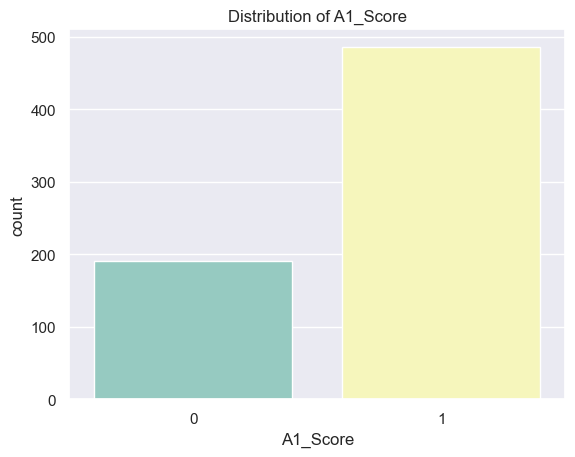

A2_Score
0    55.096012
1    44.903988
Name: proportion, dtype: float64


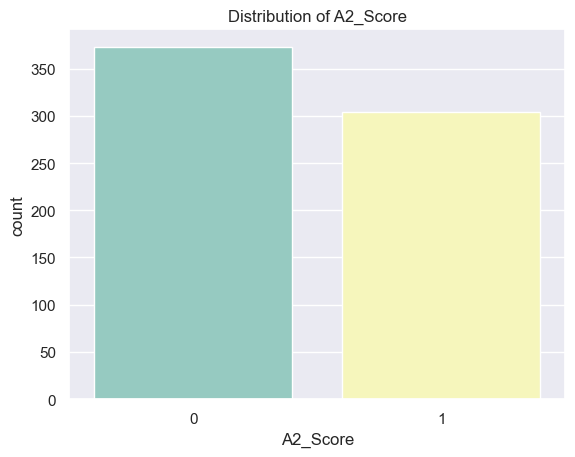

A3_Score
0    54.50517
1    45.49483
Name: proportion, dtype: float64


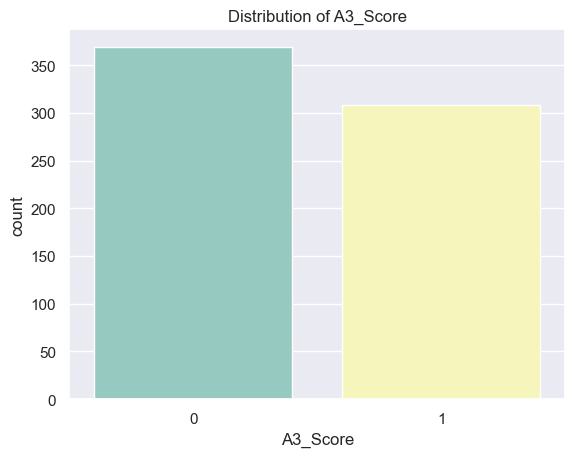

A4_Score
0    50.221566
1    49.778434
Name: proportion, dtype: float64


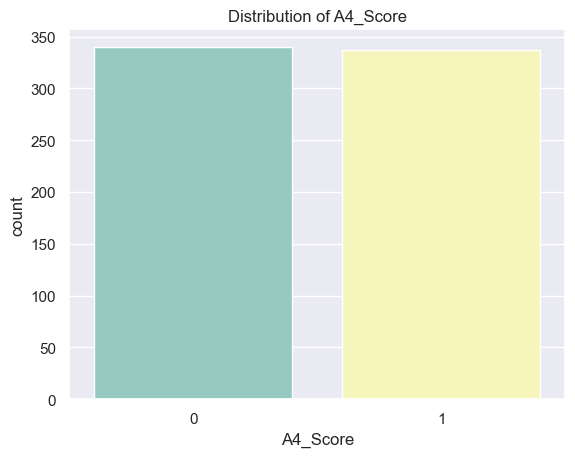

A5_Score
1    50.221566
0    49.778434
Name: proportion, dtype: float64


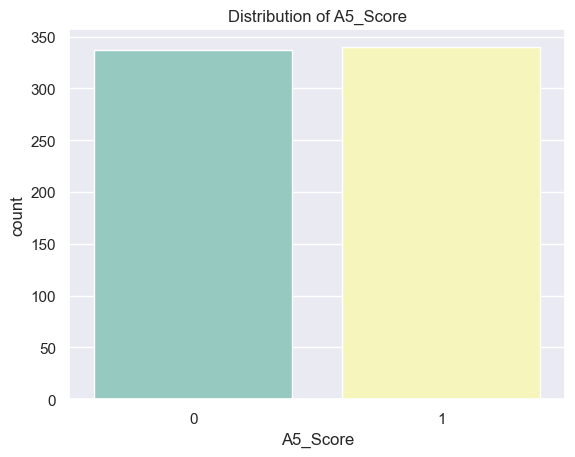

A6_Score
0    71.639586
1    28.360414
Name: proportion, dtype: float64


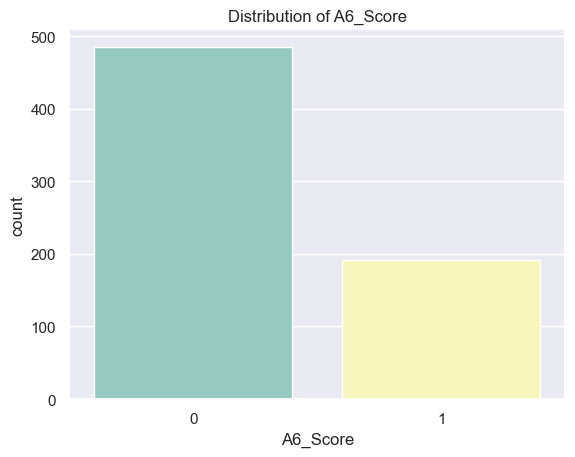

A7_Score
0    58.050222
1    41.949778
Name: proportion, dtype: float64


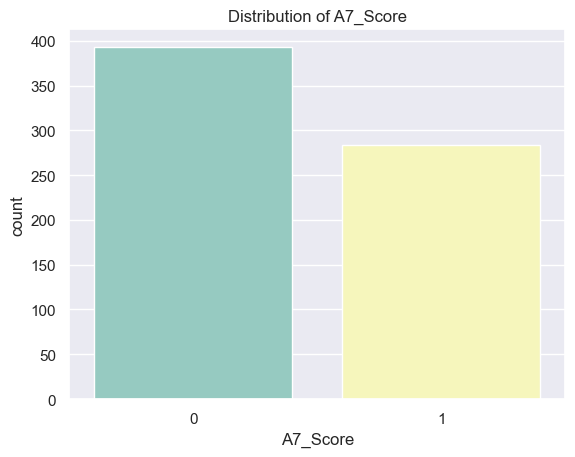

A8_Score
1    63.958641
0    36.041359
Name: proportion, dtype: float64


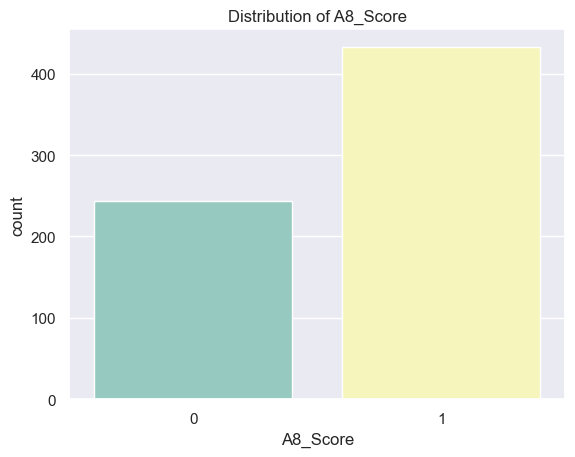

A9_Score
0    67.946824
1    32.053176
Name: proportion, dtype: float64


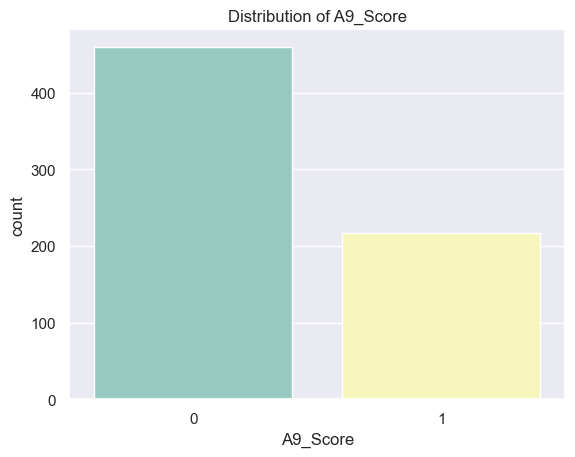

A10_Score
1    57.902511
0    42.097489
Name: proportion, dtype: float64


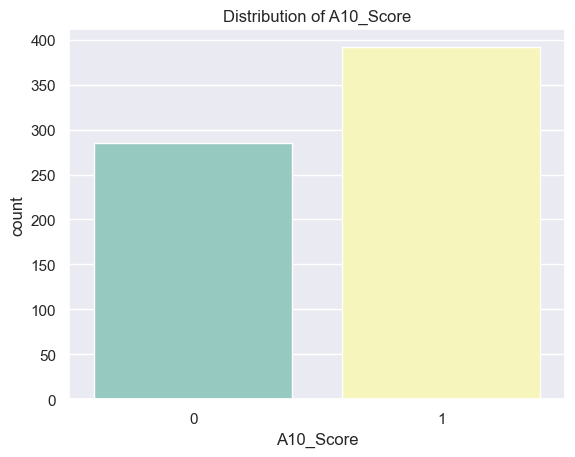

gender
m    51.698671
f    48.301329
Name: proportion, dtype: float64


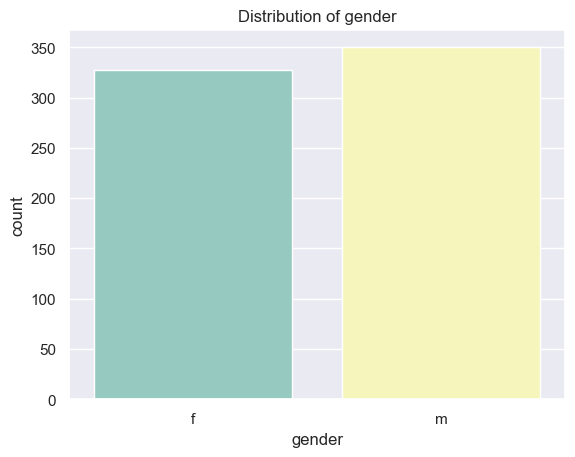

jundice
no     90.103397
yes     9.896603
Name: proportion, dtype: float64


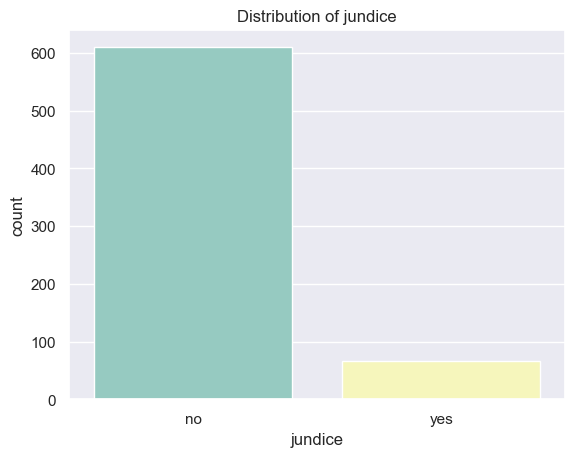

austim
no     87.296898
yes    12.703102
Name: proportion, dtype: float64


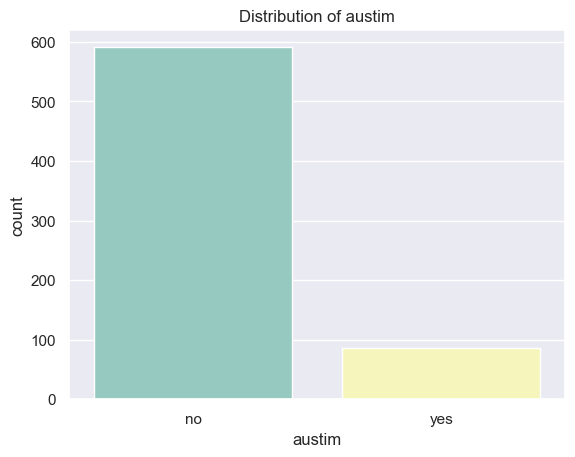

In [16]:
columns = ['A1_Score', 'A2_Score', 'A3_Score', 'A4_Score', 'A5_Score', 'A6_Score',
       'A7_Score', 'A8_Score', 'A9_Score', 'A10_Score', 'gender',
       'jundice', 'austim']

for col in columns:
    print(df[col].value_counts(normalize=True) * 100)  
    sns.countplot(data=df, x=col, palette="Set3")
    plt.title(f"Distribution of {col}")
    plt.show()

### **Data Preprocessing**

#### **Handling Missing Values**

In [17]:
df['age'] = df['age'].fillna(df['age'].median())

In [18]:
df.isna().sum()

A1_Score     0
A2_Score     0
A3_Score     0
A4_Score     0
A5_Score     0
A6_Score     0
A7_Score     0
A8_Score     0
A9_Score     0
A10_Score    0
age          0
gender       0
jundice      0
austim       0
result       0
Class/ASD    0
dtype: int64

#### **Split Features and Target**

In [19]:
X = df.drop('Class/ASD', axis=1).copy()
y = df['Class/ASD'].copy()

In [20]:
X

,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,A10_Score,age,gender,jundice,austim,result
0,1,1,1,1,0,0,1,1,0,0,26.0,f,no,no,6.0
1,1,1,0,1,0,0,0,1,0,1,24.0,m,no,yes,5.0
2,1,1,0,1,1,0,1,1,1,1,27.0,m,yes,yes,8.0
3,1,1,0,1,0,0,1,1,0,1,35.0,f,no,yes,6.0
4,1,0,0,0,0,0,0,1,0,0,40.0,f,no,no,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
699,0,1,0,1,1,0,1,1,1,1,25.0,f,no,no,7.0
700,1,0,0,0,0,0,0,1,0,1,34.0,m,no,no,3.0
701,1,0,1,1,1,0,1,1,0,1,24.0,f,no,no,7.0
702,1,0,0,1,1,0,1,0,1,1,35.0,m,no,no,6.0


In [21]:
y

0       NO
1       NO
2      YES
3       NO
4       NO
      ... 
699    YES
700     NO
701    YES
702     NO
703    YES
Name: Class/ASD, Length: 677, dtype: object

In [22]:
y.value_counts()

Class/ASD
NO     497
YES    180
Name: count, dtype: int64

#### **Handling Class Imbalance with RandomOverSampler**

In [23]:
ros = RandomOverSampler(random_state=42)
X, y = ros.fit_resample(X, y)

In [24]:
y.value_counts()

Class/ASD
NO     497
YES    497
Name: count, dtype: int64

In [25]:
X

,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,A10_Score,age,gender,jundice,austim,result
0,1,1,1,1,0,0,1,1,0,0,26.0,f,no,no,6.0
1,1,1,0,1,0,0,0,1,0,1,24.0,m,no,yes,5.0
2,1,1,0,1,1,0,1,1,1,1,27.0,m,yes,yes,8.0
3,1,1,0,1,0,0,1,1,0,1,35.0,f,no,yes,6.0
4,1,0,0,0,0,0,0,1,0,0,40.0,f,no,no,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
989,1,0,1,1,1,1,1,0,1,0,28.0,m,no,no,7.0
990,1,1,1,1,1,0,0,1,0,1,30.0,m,no,no,7.0
991,1,1,1,1,1,1,1,1,1,1,33.0,m,no,no,10.0
992,1,1,1,1,1,1,0,0,1,0,42.0,m,no,no,7.0


In [26]:
y

0       NO
1       NO
2      YES
3       NO
4       NO
      ... 
989    YES
990    YES
991    YES
992    YES
993    YES
Name: Class/ASD, Length: 994, dtype: object

#### **Map Binary Columns**

In [27]:
binary_cols = ["jundice", "austim"]

X[binary_cols] = X[binary_cols].map(lambda x: 1 if x == "YES" else 0)
X[binary_cols].head()

,jundice,austim
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0


In [28]:
y = y.map(lambda x: 1 if x == "YES" else 0)
y

0      0
1      0
2      1
3      0
4      0
      ..
989    1
990    1
991    1
992    1
993    1
Name: Class/ASD, Length: 994, dtype: int64

#### **Label Encoding for Categorical Columns**

In [29]:
le = LabelEncoder()

X['gender'] = le.fit_transform(X['gender'])
X['gender'].head()

0    0
1    1
2    1
3    0
4    0
Name: gender, dtype: int32

#### **Splitting Data into Training and Testing Sets**

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [31]:
print('X_train shape is: ', X_train.shape)
print('X_test shape is: ', X_test.shape)
print('y_train shape is: ', y_train.shape)
print('y_test shape is: ', y_test.shape)

X_train shape is:  (795, 15)
X_test shape is:  (199, 15)
y_train shape is:  (795,)
y_test shape is:  (199,)


### **Artificial Neural Network (ANN)**

In [32]:
early_stopping = callbacks.EarlyStopping(
    patience=10,
    min_delta=0.001,
    restore_best_weights=True
)

In [33]:
model = Sequential()
model.add(Input(shape=(X_train.shape[1],)))
model.add(Dense(
    64, activation='relu',
    kernel_regularizer=regularizers.l1(0.001),
    kernel_initializer=GlorotUniform(seed=42)
))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(
    512, activation='relu',
    kernel_regularizer=regularizers.l1(0.001),
    kernel_initializer=GlorotUniform(seed=42)
))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(
    256, activation='relu',
    kernel_regularizer=regularizers.l1(0.001),
    kernel_initializer=GlorotUniform(seed=42)
))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(
    64, activation='relu',
    kernel_regularizer=regularizers.l2(0.001),
    kernel_initializer=GlorotUniform(seed=42)
))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(
    32, activation='relu',
    kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.001),
    bias_regularizer=regularizers.l2(0.001),            
    activity_regularizer=regularizers.l2(0.001),       
    kernel_initializer=GlorotUniform(seed=42)
))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 64)                  │           1,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 512)                 │          33,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 64)                  │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 187,905 (734.00 KB)

 Trainable params: 186,049 (726.75 KB)

 Non-trainable params: 1,856 (7.25 KB)

In [34]:
history = model.fit(X_train, y_train, batch_size=30, epochs=100, validation_split=0.2, callbacks=[early_stopping], verbose=1)

Epoch 1/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - accuracy: 0.6618 - loss: 9.4296 - val_accuracy: 0.8050 - val_loss: 8.1874
Epoch 2/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8642 - loss: 8.4427 - val_accuracy: 0.8050 - val_loss: 7.6668
Epoch 3/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8706 - loss: 7.7784 - val_accuracy: 0.8113 - val_loss: 7.2373
Epoch 4/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8312 - loss: 7.3137 - val_accuracy: 0.8742 - val_loss: 6.8578
Epoch 5/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8795 - loss: 6.8463 - val_accuracy: 0.9308 - val_loss: 6.4953
Epoch 6/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8930 - loss: 6.4616 - val_accuracy: 0.9497 - val_loss: 6.1869
Epoch 7/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8782 - loss: 6.1695 - val_accuracy: 0.9057 - val_loss: 5.8853
Epoch 8/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8863 - loss: 5.8468 - val_accuracy: 0.9623 -

#### **Model Evalution**

In [35]:
trainLoss, trainAccuracy = model.evaluate(X_train, y_train)
print('Training Loss is', trainLoss)
print('Training Accuracy is', trainAccuracy)
testLoss, testAccuracy = model.evaluate(X_test, y_test)
print('Testing Loss is', testLoss)
print('Testing Accuracy is', testAccuracy)

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9713 - loss: 0.6155
Training Loss is 0.6163197159767151
Training Accuracy is 0.9761006236076355
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9683 - loss: 0.6299 
Testing Loss is 0.6175217628479004
Testing Accuracy is 0.9748743772506714


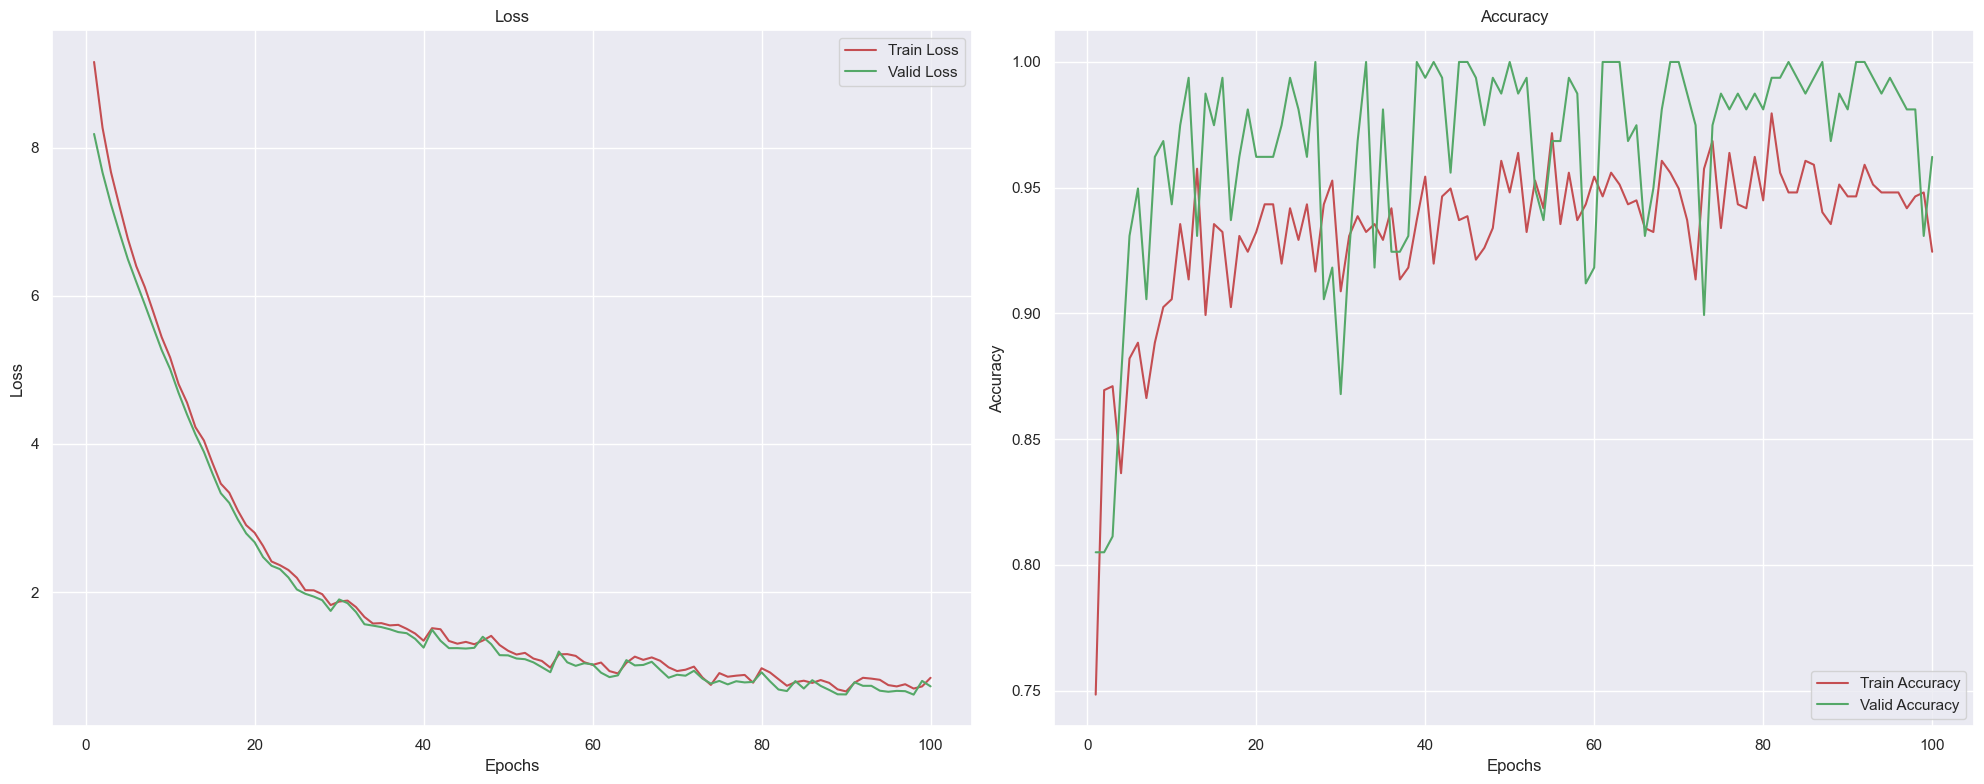

In [36]:
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

epochs = [i+1 for i in range(len(tr_acc))]

plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs, tr_loss, 'r', label='Train Loss')
plt.plot(epochs, val_loss, 'g', label='Valid Loss')
plt.title('Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.plot(epochs, tr_acc, 'r', label='Train Accuracy')
plt.plot(epochs, val_acc, 'g', label='Valid Accuracy')
plt.title('Accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.tight_layout()
plt.show()

In [37]:
y_pred = model.predict(X_test)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


In [38]:
y_pred

array([[0.88320684],
       [0.90823823],
       [0.08895794],
       [0.96188504],
       [0.886107  ],
       [0.00791121],
       [0.8500382 ],
       [0.94632345],
       [0.7640592 ],
       [0.8215608 ],
       [0.9396739 ],
       [0.01539392],
       [0.8885874 ],
       [0.58160543],
       [0.94318473],
       [0.01405006],
       [0.86098945],
       [0.00572416],
       [0.01407088],
       [0.00699164],
       [0.01113894],
       [0.04059066],
       [0.9405253 ],
       [0.04123819],
       [0.01067423],
       [0.02572558],
       [0.05371393],
       [0.333574  ],
       [0.9839271 ],
       [0.01668922],
       [0.01807367],
       [0.9753838 ],
       [0.00849518],
       [0.9513284 ],
       [0.99125874],
       [0.8885141 ],
       [0.01620037],
       [0.9291429 ],
       [0.9027076 ],
       [0.02077539],
       [0.88087785],
       [0.86366975],
       [0.83715755],
       [0.8771242 ],
       [0.02715025],
       [0.00698156],
       [0.93119174],
       [0.940

In [39]:
y_pred = [np.round(i[0]) for i in y_pred]
y_pred[:10]

[1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0]

In [40]:
CM = confusion_matrix(y_test, y_pred)
print('Confusion Matrix is \n', CM)

Confusion Matrix is 
 [[ 94   5]
 [  0 100]]


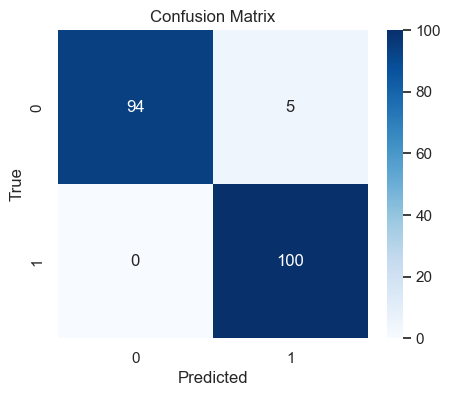

In [41]:
plt.figure(figsize=(5,4))
sns.heatmap(CM, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title(f"Confusion Matrix")
plt.show()

In [42]:
ClassificationReport = classification_report(y_test, y_pred)
print('Classification Report is: \n', ClassificationReport)

Classification Report is: 
               precision    recall  f1-score   support

           0       1.00      0.95      0.97        99
           1       0.95      1.00      0.98       100

    accuracy                           0.97       199
   macro avg       0.98      0.97      0.97       199
weighted avg       0.98      0.97      0.97       199



In [43]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")

Accuracy:  0.9749
Precision: 0.9524
Recall:    1.0000
F1 Score:  0.9756


In [44]:
precision_macro = precision_score(y_test, y_pred, average='macro')
recall_macro = recall_score(y_test, y_pred, average='macro')
f1_macro = f1_score(y_test, y_pred, average='macro')

print(f"Macro Avg Precision: {precision_macro:.4f}")
print(f"Macro Avg Recall:    {recall_macro:.4f}")
print(f"Macro Avg F1 Score:  {f1_macro:.4f}")

Macro Avg Precision: 0.9762
Macro Avg Recall:    0.9747
Macro Avg F1 Score:  0.9749


In [45]:
pred = model.predict(X_test.sample())
prob = pred[0][0]

label = 1 if prob >= 0.5 else 0

print("Probability:", prob)
print("Predicted Class:", label)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Probability: 0.9737371
Predicted Class: 1


#### **Export Model and Preprocessing Pipeline**

In [48]:
joblib.dump(le, 'LabelEncoder.pkl')
model.save('ANN.h5')

## **Final Thoughts**

This project showcased the application of Artificial Neural Networks for autism screening prediction, leveraging survey-based behavioral, demographic, and medical history features.  
By performing thorough data exploration, preprocessing, and the use of oversampling to balance classes, the model was able to achieve **high accuracy and excellent precision-recall balance**—highlighting its potential effectiveness in real-world screening scenarios.

Key techniques such as **regularization, dropout, batch normalization, and early stopping** played a crucial role in ensuring that the ANN generalized well without overfitting, while still capturing meaningful patterns in the data.

The deployment of the model as a **Streamlit application** provides an accessible, interactive platform for real-time autism likelihood predictions, demonstrating how data-driven solutions can complement traditional screening methods and support decision-making in healthcare contexts.

---

**Thank you for exploring this project.**